# Dataset

> API details.

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
#export
import copy

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import pandas as pd
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl

from tqdm import tqdm

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from isic.config import *

C:\Users\bomco\miniconda3\envs\devtorch\lib\site-packages\pytorch_lightning\utilities\distributed.py:23: UserWarning: Unsupported `ReduceOp` for distributed computing.
  warnings.warn(*args, **kwargs)


In [ ]:
#export
class SkinLabels():
    lesion_type_dict = {
        'nv': 'Melanocytic nevi',
        'mel': 'Melanoma',
        'bkl': 'Benign keratosis-like lesions ',
        'bcc': 'Basal cell carcinoma',
        'akiec': 'Actinic keratoses',
        'vasc': 'Vascular lesions',
        'df': 'Dermatofibroma'
    }

    lesion_type_vi_dict = {
        'nv': 'Nốt ruồi',
        'mel': 'Ung thư hắc tố',
        'bkl': 'U sừng hóa ác tính ',
        'bcc': 'U da ung thư tế bào đáy',
        'akiec': 'Dày sừng quang hóa',
        'vasc': 'Thương tổn mạch máu',
        'df': 'U da lành tính'
    }

In [ ]:
PathConfig.CSV_PATH

'D:\\Workspace\\ML\\HAM10000\\data\\HAM10000_metadata.csv'

In [ ]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [ ]:
#export
def preprocess_df(df, valid_size=0.2, seed=AppConfig.SEED, image_label_only=False):

    df['path'] = PathConfig.IMAGE_PATH + '/' + df['image_id'] + '.jpg'
    df['label_fullstr'] = df['dx'].map(SkinLabels.lesion_type_dict.get)

    label_str = pd.Categorical(df['label_fullstr'])
    df['label_index'] = label_str.codes

    df_undup = df.groupby('lesion_id').count()
    df_undup = df_undup[df_undup['image_id'] == 1]
    df_undup.reset_index(inplace=True)

    _, valid = train_test_split(df_undup['lesion_id'], test_size=valid_size, 
                                random_state=seed, 
                                stratify=df_undup['label_index'])
    valid = set(valid)
    df['val'] = df['lesion_id'].apply(lambda x: 1 if str(x) in valid else 0)

    df_train = df[df['val'] == 0]
    df_valid = df[df['val'] == 1]

    dest_df_train = df_train.reset_index(drop=True)
    dest_df_valid = df_valid.reset_index(drop=True)
    if not image_label_only:
        return dest_df_train, dest_df_valid, list(label_str.categories)
    else:
        train_imgs = []
        val_imgs = []
        i = 0
        for df in (dest_df_train, dest_df_valid):
            for j, path in enumerate(df['path']):
                x = np.array(Image.open(path))
                y = torch.tensor(int(df['label_index'][j]))
                if i == 0:
                    train_imgs.append((x, y))
                else:
                    val_imgs.append((x, y))
            i += 1
        return train_imgs, val_imgs, list(label_str.categories)

In [ ]:
df = pd.read_csv(PathConfig.CSV_PATH)
train_df, valid_df, labels = preprocess_df(df, image_label_only=False)

In [ ]:
compute_img_mean_std(train_df['path'])

In [ ]:
train_df.shape, valid_df.shape

((8912, 11), (1103, 11))

In [ ]:
train_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,label_fullstr,label_index,val
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,D:\Workspace\ML\HAM10000\data\images/ISIC_0027...,Benign keratosis-like lesions,2,0
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,D:\Workspace\ML\HAM10000\data\images/ISIC_0025...,Benign keratosis-like lesions,2,0
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,D:\Workspace\ML\HAM10000\data\images/ISIC_0026...,Benign keratosis-like lesions,2,0
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,D:\Workspace\ML\HAM10000\data\images/ISIC_0025...,Benign keratosis-like lesions,2,0
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,D:\Workspace\ML\HAM10000\data\images/ISIC_0031...,Benign keratosis-like lesions,2,0
...,...,...,...,...,...,...,...,...,...,...,...
8907,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,D:\Workspace\ML\HAM10000\data\images/ISIC_0033...,Actinic keratoses,0,0
8908,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,D:\Workspace\ML\HAM10000\data\images/ISIC_0033...,Actinic keratoses,0,0
8909,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,D:\Workspace\ML\HAM10000\data\images/ISIC_0033...,Actinic keratoses,0,0
8910,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,D:\Workspace\ML\HAM10000\data\images/ISIC_0032...,Actinic keratoses,0,0


In [ ]:
#export
class SkinDataset(Dataset):
    def __init__(self, df, transform=None, labels=None):
        self.df = df
        self.transform = transform
        self.labels = labels

    def __getitem__(self, i):
        if i >= len(self): raise IndexError
        x = Image.open(self.df['path'][i])
        y = torch.tensor(int(self.df['label_index'][i]))

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.df)

    def show_image(self, index=None):
        dataset = self
        n_samples = len(dataset)

        if not index:
            index = int(np.random.random()*n_samples)
        else:
            if index >= n_samples or index < 0:
                print('Invalid index.')
                return

        x, y = dataset[index]

        plt.imshow(x.permute(1,2,0))
        plt.axis('off')
        plt.title(self.labels[y] if self.labels else y)

    def show_grid(self, n_rows=5, n_cols=5):
        dataset = self
        array = torch.utils.data.Subset(dataset, np.random.choice(len(dataset), n_rows*n_cols, replace=False))

        plt.figure(figsize=(12, 12))
        for row in range(n_rows):
            for col in range(n_cols):
                index = n_cols * row + col
                plt.subplot(n_rows, n_cols, index + 1)
                plt.imshow(array[index][0].permute(1, 2, 0))
                plt.axis('off')
                label = self.labels[int(array[index][1])] if self.labels else int(array[index][1])
                plt.title(label, fontsize=12)
        plt.tight_layout()

In [ ]:
#export
#(mean=[0.7506, 0.5257, 0.5473],std=[0.1037, 0.1340, 0.1499]): std accumulated by var
class SkinDataModule(pl.LightningDataModule):
    def __init__(self, df_path=PathConfig.CSV_PATH, transform=None, valid_size=0.2, bs=64):
        self.df_path = df_path
        self.valid_size = 0.2
        self.bs = bs
        if not transform:
            self.transform = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
#                 transforms.Normalize(mean=[0.7579628, 0.5485365, 0.5737883],
#                                      std=[0.1419983, 0.15297663, 0.17065412])
            ])

        self.dims = (3, 224, 224)

    def setup(self, stage):
        if stage == 'fit' or stage is None:
            df = pd.read_csv(PathConfig.CSV_PATH)
            train_df, valid_df, self.labels = preprocess_df(df, self.valid_size)
            self.train_ds = SkinDataset(train_df, self.transform, self.labels)
            self.val_ds = SkinDataset(valid_df, self.transform, self.labels)

            self.dims = tuple(self.train_ds[0][0].shape)

        if stage == 'test':
            #TODO
            pass

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.bs, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.bs, num_workers=4)

    def test_dataloader(self):
        #TODO
        return DataLoader(self.val_ds, batch_size=self.bs, num_workers=4)

In [ ]:
test = SkinDataModule()
test.setup('fit')

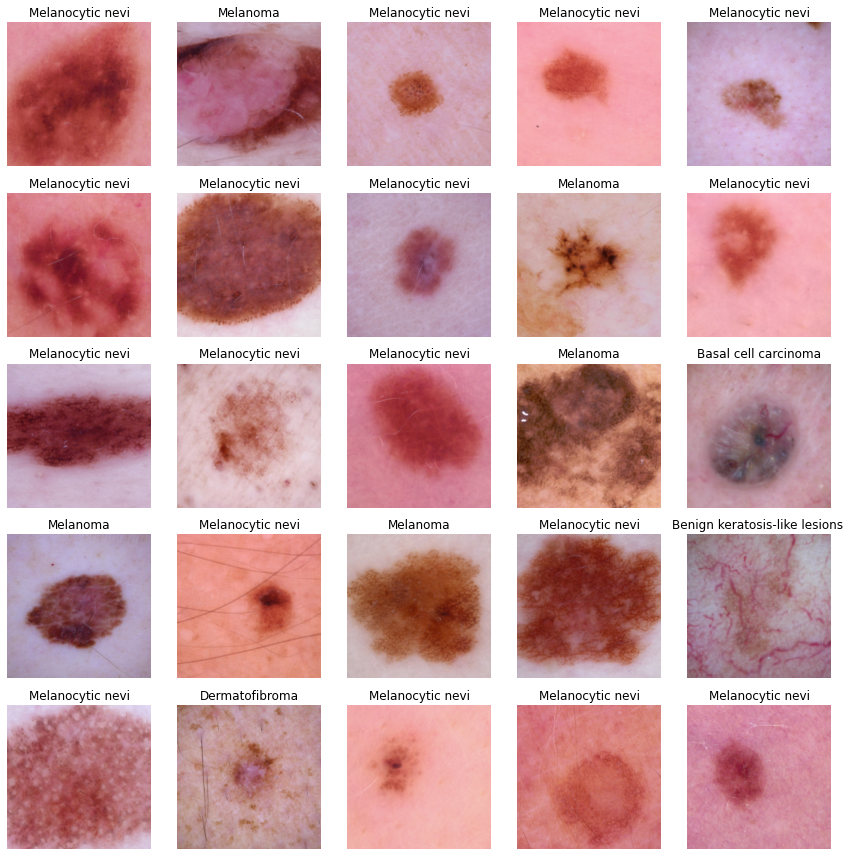

In [ ]:
test.train_ds.show_grid()

In [ ]:
def calculate_stats_varaccum(train_dl):
    nimages = 0
    mean = 0.0
    var = 0.0
    for i_batch, batch_target in enumerate(train_dl):
        batch = batch_target[0]
        # Rearrange batch to be the shape of [B, C, W * H]
        batch = batch.view(batch.size(0), batch.size(1), -1)
        # Update total number of images
        nimages += batch.size(0)
        # Compute mean and std here
        mean += batch.mean(2).sum(0) 
        var += batch.var(2).sum(0)

    mean /= nimages
    var /= nimages
    std = torch.sqrt(var)
    
    return mean, std

In [ ]:
#export
class SkinDataBunch:
    def __init__(self, train_dl, valid_dl, labels):
        self.train_dl,self.valid_dl,self.labels, self.c = train_dl,valid_dl,labels,len(labels)

    @property
    def train_ds(self): return self.train_dl.dataset

    @property
    def valid_ds(self): return self.valid_dl.dataset

    def show_image(self, index=None):
        dataset = self.train_ds
        dataset.show_image(index)

    def show_grid(self, n_rows=5, n_cols=5):
        dataset = self.train_ds
        dataset.show_grid(n_rows, n_cols)

In [ ]:
db = SkinDataBunch(train_dl, valid_dl, labels)

In [ ]:
#export
def get_skin_databunch(size=100, transform=None):
    df = pd.read_csv(PathConfig.CSV_PATH)
    train_df, valid_df, labels = preprocess_df(df)
    if not transform:
        transform = transforms.Compose([
            transforms.ToTensor()
        ])
    train_ds = SkinDataset(train_df[:size], transform)
    valid_ds = SkinDataset(valid_df[:size], transform)
    train_dl = DataLoader(train_ds, batch_size=TrainConfig.BATCH_SIZE, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=TrainConfig.BATCH_SIZE)
    db = SkinDataBunch(train_dl, valid_dl, labels)
    return db